In [1]:
from functional import *
from transformer_forecast import timeseries_transformer
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error

2024-09-27 01:04:42.820718: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-27 01:04:42.833000: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-27 01:04:42.836322: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-27 01:04:42.848364: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-27 01:04:43.722541: W tensorflow/compiler/tf2

In [2]:
class transfer_learning(funtional):
    def __init__(self,timeframe):
        self.timeframe=timeframe
        with open(os.path.join(Path().cwd(),'parameter.json'),'r') as f:
            params=json.load(f)
            self.symbol=params['symbol']
            self.test_size=params['test_size']
            self.ma_length=params['ma_length']
            self.price_type=params['price_type']
            self.seq_length=params['seq_length']

        self.pretrained_transformer=timeseries_transformer().build()
        self.pretrained_transformer.load_weights(os.path.join(Path().cwd(),f'models/transformer_{self.price_type}_{self.symbol}_1d.weights.h5'))
        self.pretrained_transformer.trainable=False

        self.df=pd.read_csv(os.path.join(Path().cwd(),f'data/{self.symbol}/{self.symbol}_{self.timeframe}.csv'),index_col=0,parse_dates=True)
        self.df['price']=self.df['Close']
        self.df['log']=np.log(self.df['Close'])
        self.df['moving_average']=self.df['price'].rolling(self.ma_length).mean()
        self.df['diff']=(self.df['price']-self.df['moving_average']).dropna()
        self.df.dropna(inplace=True)        

        self.x,self.y=[],[]
        for i in range(len(self.df[self.price_type])-self.seq_length-1):
            self.x.append(self.df[self.price_type].iloc[i:i+self.seq_length].tolist())
            self.y.append(self.df[self.price_type].iloc[i+self.seq_length]) 
        self.x,self.y=np.array(self.x),np.array(self.y)

        index=int(self.x.shape[0]*(1-self.test_size))
        self.x_train=self.x[:index]
        self.y_train=self.y[:index]
        self.x_test=self.x[index:]
        self.y_test=self.y[index:]

    def sape(self,true_value,predict_value):
        average_volatility=pd.Series(true_value).pct_change().abs().mean()
        mape=mean_absolute_percentage_error(true_value,predict_value)
        scaled_perentage_error=mape/average_volatility
        return scaled_perentage_error

    def predict(self,true_value,predict_value):
        self.methods={'mae':mean_absolute_error,'mape':mean_absolute_percentage_error,'sape':self.sape}
        metrics,method_name=[],[]
        for name,method in self.methods.items():
            metrics.append(method(true_value,predict_value))
            method_name.append(name)
        return pd.Series(metrics,index=method_name)

    def compare(self):
        model_predict=self.model.predict(self.x).reshape(-1)
        self.predict(self.y,model_predict)
        return self.predict(self.y,model_predict)

    def build(self):
        input_layer=tf.keras.layers.Input((self.seq_length,1))
        pretrained_layer=self.pretrained_transformer(input_layer)
        dense_layer=tf.keras.layers.Dense(100,activation=activation)(pretrained_layer)
        dense_layer=tf.keras.layers.Dense(50,activation=activation)(dense_layer)
        dense_layer=tf.keras.layers.Dense(20,activation=activation)(dense_layer)
        dense_layer=tf.keras.layers.Dense(10,activation=activation)(dense_layer)
        dense_layer=tf.keras.layers.Dense(5,activation=activation)(dense_layer)
        dense_layer=tf.keras.layers.Dense(2,activation=activation)(dense_layer)
        output_layer=tf.keras.layers.Dense(1,activation=activation)(dense_layer)
        model=tf.keras.Model(input_layer,output_layer)

        return model
    
    def train(self,epochs=10,optimizer='adam',loss='mae',batch_size=32):
        self.model=self.build()
        self.model.compile(optimizer=optimizer,loss=loss)
        best_lost=tf.keras.callbacks.ModelCheckpoint(os.path.join(Path().cwd(),f'models/transfer_{self.price_type}_{self.symbol}_{self.timeframe}.keras'),monitor='loss',mode='min',save_best_only=True)
        self.history=self.model.fit(self.x_train,self.y_train,epochs=epochs,batch_size=batch_size,callbacks=[best_lost],validation_data=(self.x_test,self.y_test))
        self.pred=self.model.predict(self.x).reshape(-1)
        

In [3]:
timeframe='4h'
model=transfer_learning(timeframe=timeframe)

2024-09-27 01:04:45.793493: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [4]:
model.train(epochs=10,loss='mape')

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 62.1747 - val_loss: 0.9258
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1.7286 - val_loss: 1.4562
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 1.5139 - val_loss: 0.4921
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 1.0433 - val_loss: 0.2459
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.7072 - val_loss: 0.9257
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.5913 - val_loss: 1.3870
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.4798 - val_loss: 0.2456
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.3949 - val_loss: 0.2942
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.4082 - val_loss: 0.2494
Epoch 10/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.5075 - val_loss: 0.5586
285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


In [5]:
model.compare()

285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


mae     0.005237
mape    0.004746
sape    3.994839
dtype: float64

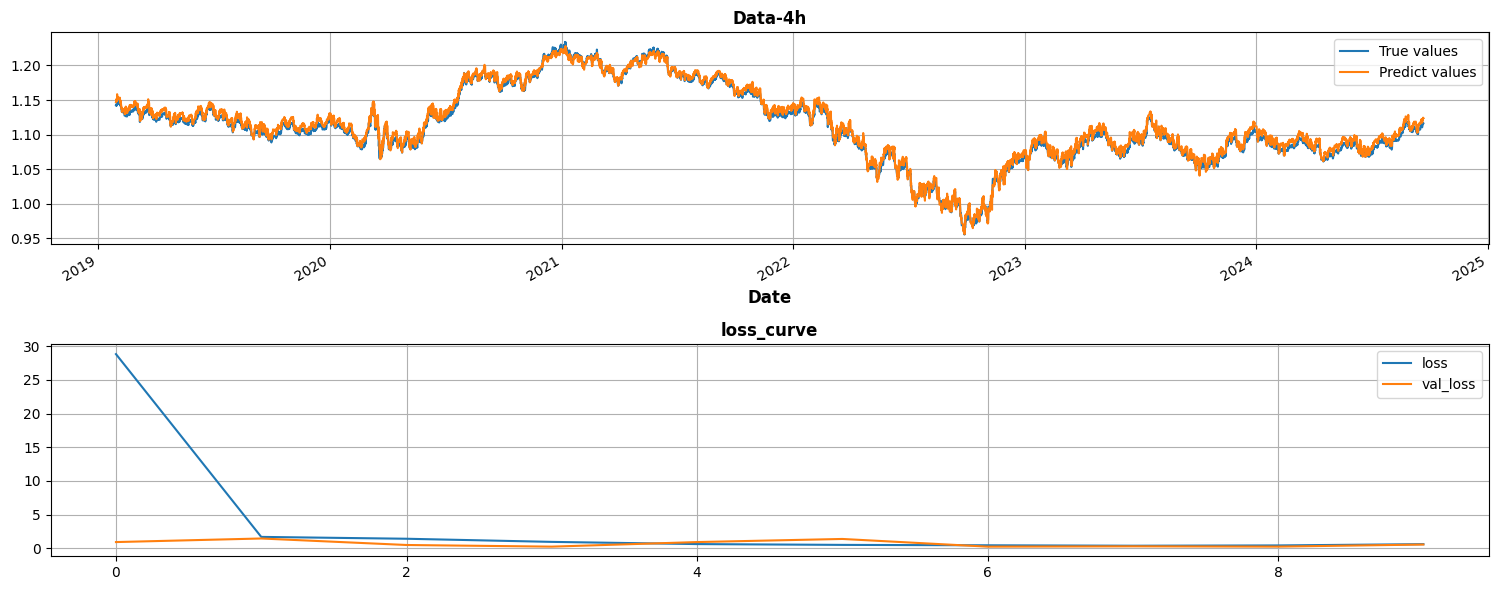

In [6]:
model.plot_summary()